In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal']

In [4]:
df = data[data['goal'] >= 5]

In [18]:
df.fillna(df.median())

,pled,goal,period,text_am,n_img,n_vid,n_pled_t,min_pled_t,max_pled_t,mean_pled_t,...,mmo,indie,action,quest,adventure,mgp,cont,succsess,is_site,succes_type
0,16.37,16368.00,14,355,7,0,8,1.64,8184.00,1206.321250,...,0,0,0,0,0,0.653856,0.276952,0,0,0
1,124761.28,7278.02,30,2218,33,3,5,3.64,99.71,43.960000,...,0,0,1,0,0,6.105621,0.220415,1,1,8
2,1211.00,35000.00,31,3174,19,3,13,5.00,1000.00,312.692308,...,0,1,0,0,0,2.556285,0.289384,0,1,0
3,1.00,10000.00,14,110,0,0,3,25.00,1000.00,425.000000,...,0,0,0,0,0,0.000000,0.000000,0,1,0
4,5415.00,67000.00,30,3955,46,1,15,1.00,1000.00,165.866667,...,0,0,1,0,1,5.987628,0.256332,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8416,2246.00,7000.00,60,912,10,0,8,10.00,1000.00,366.875000,...,0,1,0,1,0,3.246320,0.220351,0,1,1
8417,18021.00,15000.00,45,1650,39,2,23,1.00,8000.00,733.434783,...,0,0,0,0,0,8.707396,0.230234,1,1,4
8418,14.00,10000.00,30,280,10,1,9,1.00,200.00,67.888889,...,0,0,0,0,0,2.763008,0.328798,0,0,0
8419,82.88,3928.54,31,777,0,0,7,4.60,92.09,40.124286,...,1,0,0,1,0,0.000000,0.000000,0,0,0


In [19]:
# Remove emissions
df = data
df = df[df['goal'] > 5]
df = df[df['period'] < 80]
df = df[df['n_vid'] < 10]
df['created'].fillna(0, inplace=True)
df['site'].fillna('', inplace=True)

# Using 3 sigmas rule
n_sigmas = 3

created_std = df['created'].std() # Taken from description
created_mean = df['created'].mean()
df['created'] = df['created'][(df['created'] >= created_mean - created_std * n_sigmas) & (df['created'] <= created_mean + created_std * n_sigmas)]

In [6]:
def get_type(rate):
    type_ = 0
    for i in np.linspace(0, 1.75, 8):
        if rate < i + 0.25:
            return type_
        type_ += 1
    return 8

In [7]:
# Add success type

types = []

for idx, row in df.iterrows():
    types.append(get_type(row[-1]))

types = pd.Series(types, dtype=int)
df = df.assign(succes_type=types.values)
if 'success_rate' in df.columns:
    df = df.drop(columns='success_rate')
if 'success' in df.columns:
    df = df.drop(columns='success')

In [8]:
numeric_data = df.corr().columns[1:]
target_col = df.corr().columns[-1]

print(numeric_data, target_col)

df = df[numeric_data]
target = df[target_col]

Index(['pled', 'goal', 'period', 'text_am', 'n_img', 'n_vid', 'n_pled_t',
       'min_pled_t', 'max_pled_t', 'mean_pled_t', 'step_pled_t', 'cr_time',
       'backed', 'created', 'rpg', 'platformer', 'shooter', 'fighting',
       'survival', 'horror', 'strategy', 'arcade', 'simulator', 'mmo', 'indie',
       'action', 'quest', 'adventure', 'mgp', 'cont', 'succsess', 'is_site',
       'succes_type'],
      dtype='object') succes_type


In [9]:
model = nn.Sequential(
    nn.BatchNorm1d(32),
    nn.Linear(32, 24),
    nn.ReLU(),
    nn.BatchNorm1d(24),
    nn.Linear(24, 20),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Linear(20, 10))

optimizer = Adam(model.parameters())
loss_fn = F.cross_entropy

In [10]:
class MyDataset:
    def __init__(self, df):
        self.df = pd.DataFrame(data=df)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        return torch.Tensor(df.iloc[i])[:-1], torch.Tensor(df.iloc[i])[-1].to(torch.long)

In [11]:
from torch.utils.data import DataLoader


train, test = train_test_split(df, train_size=0.8)

train_loader = DataLoader(MyDataset(train), batch_size=24, shuffle=True)
test_loader = DataLoader(MyDataset(test), batch_size=24)

In [12]:
model.train()

losses = []
accuracies = []

for epochs in tqdm(range(10)):
    epoch_losses = []
    epoch_accuracies = []
    for xb, yb in tqdm(train_loader):
        accuracy = 0
        correct_answers = 0
        
        optimizer.zero_grad()

        outp = model(xb)
        loss = loss_fn(outp, yb)

        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        epoch_accuracies.append(accuracy)
    
    losses.append(torch.tensor(epoch_losses).mean())
    accuracies.append(torch.tensor(epoch_accuracies).mean())
    
    print('loss:', losses[-1])
    print('accuracy: ', accuracies[-1])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(1.2732)
accuracy:  tensor(0.6548)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.7481)
accuracy:  tensor(0.7616)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.6904)
accuracy:  tensor(0.7662)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.6560)
accuracy:  tensor(0.7719)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.6457)
accuracy:  tensor(0.7712)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.6296)
accuracy:  tensor(0.7798)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.6074)
accuracy:  tensor(0.7828)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.6037)
accuracy:  tensor(0.7785)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.5957)
accuracy:  tensor(0.7820)


  0%|          | 0/281 [00:00<?, ?it/s]

loss: tensor(0.5789)
accuracy:  tensor(0.7930)


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

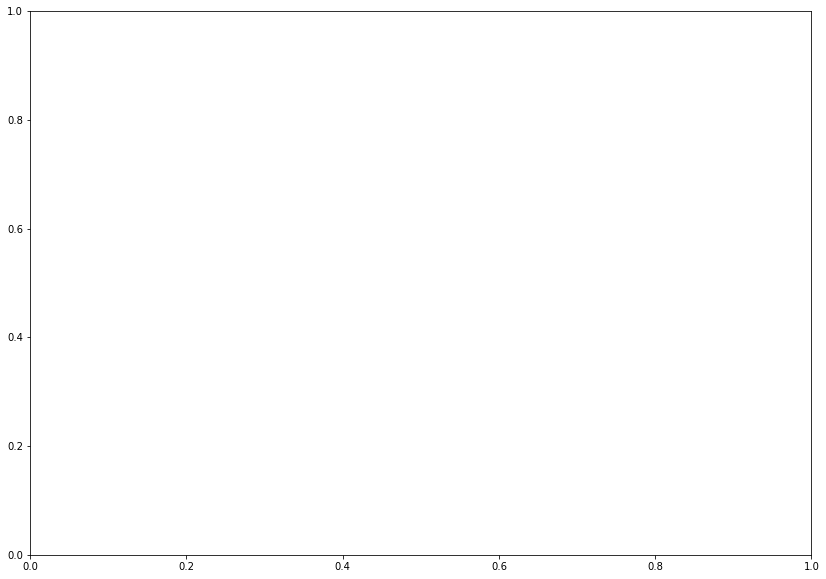

In [17]:
plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), losses, label='loss')

plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), accuracies, label='accuracy', c='r')

In [14]:
model.eval()

losses = []
accuracies = []

for xb, yb in test_loader:
    with torch.no_grad():
        outp = model(xb)
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        accuracies.append(accuracy)
torch.Tensor(accuracies).mean()

tensor(0.7007)

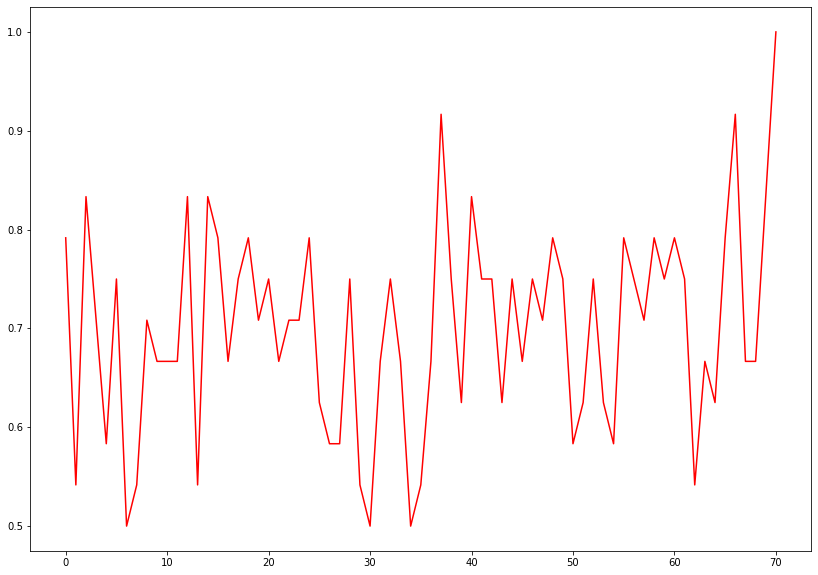

In [15]:
plt.figure(figsize=(14, 10))
plt.plot(np.arange(len(test_loader)), accuracies, label='accuracy', c='r')